In [28]:
import pandas as pd
import numpy as np

file_station_a = "station_a.csv"
file_station_c = "station_c.csv"
file_station_main = "station_main.csv"
file_all_station = "station_all.csv"

In [29]:
station_a = pd.read_csv(file_station_a, index_col="time", parse_dates=True)
station_c = pd.read_csv(file_station_c, index_col="time", parse_dates=True)
station_main = pd.read_csv(file_station_main, index_col="time", parse_dates=True)

In [31]:
station_a.describe()

,temp_c,rain_mm
count,89546.000000,89546.000000
mean,9.210997,-0.038644
std,7.159731,11.575755
min,-20.100000,-999.000000
25%,4.100000,0.000000
50%,9.100000,0.000000
75%,14.400000,0.000000
max,33.400000,38.000000


In [4]:
station_a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90451 entries, 2007-09-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   temp_c   89546 non-null  float64
 1   status   89546 non-null  object 
 2   rain_mm  89546 non-null  float64
dtypes: float64(2), object(1)
memory usage: 2.8+ MB


# Range Check

## station_main (Willenscharen)

<AxesSubplot:xlabel='time'>

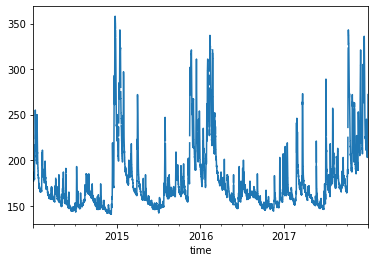

In [5]:
station_main.level_cm.plot()

<AxesSubplot:xlabel='time'>

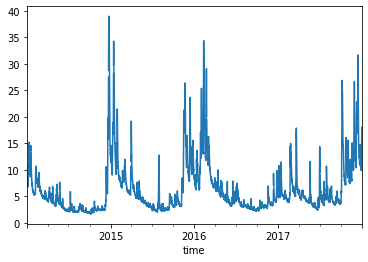

In [6]:
station_main.flow_m3_s.plot()

In [7]:
print(min(station_main.level_cm), min(station_main.flow_m3_s))

141.0 1.69


Logically, both water level and water have to be positive. This is the case here. Otherwise, negative values would be marked as missing value (NaN).

## Station A (Padenstedt) and Station C (Itzehoe)

### rain_mm

This attribute describes precipitation (snow and in Schleswig-Holstein mostly rain). Has to be positive.

count    89546.000000
mean        -0.038644
std         11.575755
min       -999.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         38.000000
Name: rain_mm, dtype: float64


<AxesSubplot:xlabel='time'>

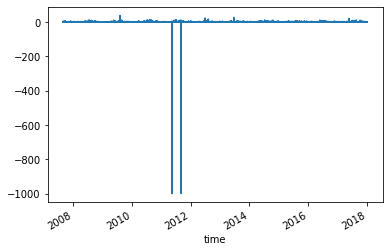

In [8]:
print(station_a.rain_mm.describe())
station_a.rain_mm.plot()

count    125108.000000
mean         -1.055931
std          33.997841
min        -999.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          24.200000
Name: rain_mm, dtype: float64
AxesSubplot(0.125,0.2;0.775x0.68)


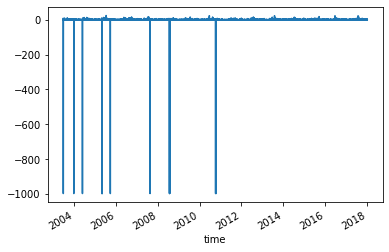

In [9]:
print(station_c.rain_mm.describe())
print(station_c.rain_mm.plot())

Both rain levels have some fixed value -999. These are assumed to be missing values:

In [10]:
station_a.isna().sum()

temp_c     905
status     905
rain_mm    905
dtype: int64

In [11]:
station_a.loc[station_a.rain_mm < 0, "rain_mm"] = np.nan
station_c.loc[station_c.rain_mm < 0, "rain_mm"] = np.nan

### temp_c

This attribute describes the air temperature. A sensible range to check for are based on the min. and max. temperature ever recorded in Germany: [-40°C, 42°C]

(see <https://de.wikipedia.org/wiki/Liste_der_Temperaturrekorde_in_Deutschland#Hitzerekorde>):

count    89546.000000
mean         9.210997
std          7.159731
min        -20.100000
25%          4.100000
50%          9.100000
75%         14.400000
max         33.400000
Name: temp_c, dtype: float64


<AxesSubplot:xlabel='time'>

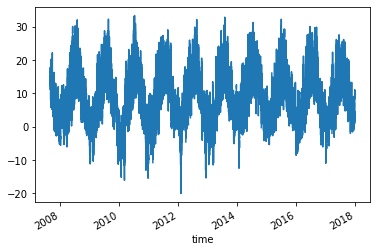

In [12]:
print(station_a.temp_c.describe())
station_a.temp_c.plot()

count    125108.000000
mean          9.473741
std           7.749278
min        -999.000000
25%           4.300000
50%           9.400000
75%          14.700000
max          36.300000
Name: temp_c, dtype: float64


<AxesSubplot:xlabel='time'>

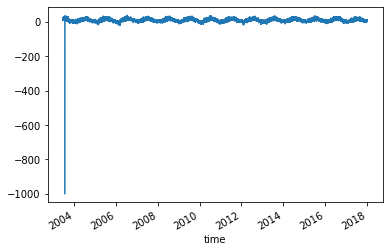

In [13]:
print(station_c.temp_c.describe())
station_c.temp_c.plot()

Station A is fine, but Station C has - like with the precipitation - a articifcal value of -999 which we interpret as missing value:

In [14]:
station_c.loc[station_c.temp_c < -40, "temp_c"] = np.nan

# Missing Values

All attributes show missing values:

In [15]:
print(station_a.isna().sum())
print()
print(station_c.isna().sum())
print()
print(station_main.isna().sum())

temp_c     905
status     905
rain_mm    917
dtype: int64

temp_c     1265
status     1274
rain_mm    1409
dtype: int64

level_cm     351
flow_m3_s    351
dtype: int64


For the categorical attribute status we use forward filling - without any limitation on how many consecutive NaNs can be replaced at a time.

In [16]:
station_a.status.interpolate(method="pad", inplace=True)
station_c.status.interpolate(method="pad", inplace=True)

For the numerical attributes we use linear interpolation

In [17]:
station_a.temp_c.interpolate(method="linear", inplace=True)
station_c.temp_c.interpolate(method="linear", inplace=True)

station_a.rain_mm.interpolate(method="linear", inplace=True)
station_c.rain_mm.interpolate(method="linear", inplace=True)

station_main.level_cm.interpolate(method="linear", inplace=True)
station_main.flow_m3_s.interpolate(method="linear", inplace=True)

# Scaling

## Time Domain

The sampling interval is the same for all station (hourly, starting at 00:00 every day). Scaling in the time domain is not required.

## Value Domain

No scaling (yet).

Scaling due to different value ranges is not necessary (same for rain resp. temp in station A and C) and _level_cm_ is independet from _rain_mm_.

Using normalisation or standardisation for feature scaling depends on the technqiues in following stages. When using Scikit-Learn you can use a transformer called MinMaxScaler for Normalization and one called StandardScaler for standardisation.

# Encoding

Status represents increasing humidity at the station A and station B. Therefore it will rank-based encoded:

In [18]:
# Encode the status
station_a.status = pd.Categorical(station_a.status, categories = ["low", "decreased", "normal", "increased", "max"]).codes
station_c.status = pd.Categorical(station_c.status, categories = ["low", "decreased", "normal", "increased", "max"]).codes

# Final Plots / Stats

## Station Main

           level_cm     flow_m3_s
count  35063.000000  35063.000000
mean     178.088812      6.241092
std       37.141985      4.929488
min      141.000000      1.690000
25%      155.000000      3.170000
50%      165.000000      4.580000
75%      186.000000      7.410000
max      358.000000     39.000000


<AxesSubplot:xlabel='time'>

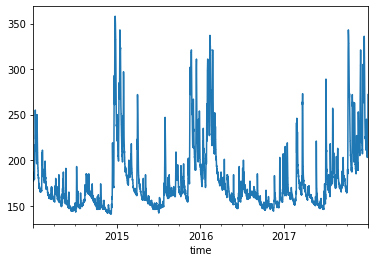

In [19]:
print(station_main.describe())
station_main.level_cm.plot()

<AxesSubplot:xlabel='time'>

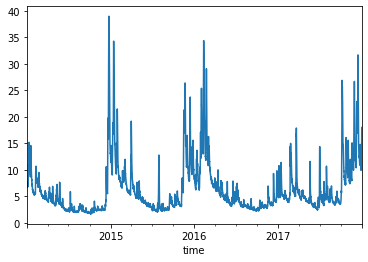

In [20]:
station_main.flow_m3_s.plot()

## Station A and Station C

In [21]:
print(station_a.describe())
print()
print(station_c.describe())

             temp_c        status       rain_mm
count  90451.000000  90451.000000  90451.000000
mean       9.207801      2.606826      0.095266
std        7.158097      1.074621      0.496063
min      -20.100000      0.000000      0.000000
25%        4.100000      2.000000      0.000000
50%        9.100000      3.000000      0.000000
75%       14.400000      3.000000      0.000000
max       33.400000      4.000000     38.000000

              temp_c         status        rain_mm
count  126372.000000  126372.000000  126372.000000
mean        9.481583       2.530576       0.101924
std         7.206107       1.062120       0.515734
min       -21.200000       0.000000       0.000000
25%         4.300000       2.000000       0.000000
50%         9.400000       3.000000       0.000000
75%        14.700000       3.000000       0.000000
max        36.300000       4.000000      24.200000


<AxesSubplot:xlabel='time'>

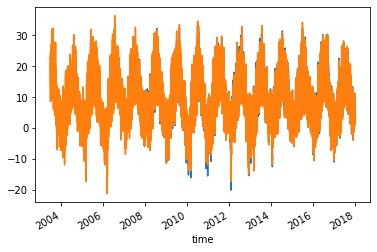

In [22]:
station_a.temp_c.plot()
station_c.temp_c.plot()

<AxesSubplot:xlabel='time'>

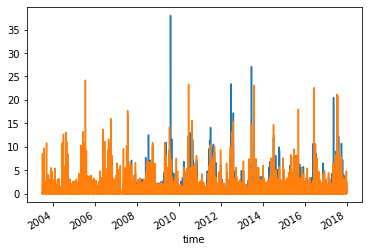

In [23]:
station_a.rain_mm.plot()
station_c.rain_mm.plot()

## Combined Data

Combine the 3 stations using an inner join on index (the datetime) incl. new column names.

In [24]:
all_stations = station_main.join(station_a.join(station_c, how="inner", rsuffix="_from_c"), how="inner")
all_stations.columns = ["main_level", "main_flow", "a_temp", "a_status", "a_rain", "c_temp", "c_status", "c_rain"]
all_stations

,main_level,main_flow,a_temp,a_status,a_rain,c_temp,c_status,c_rain
time,,,,,,,,
2014-01-01 01:00:00,182.0,7.19,2.6,2,0.0,2.8,2,0.0
2014-01-01 02:00:00,182.0,7.19,2.4,2,0.0,2.5,2,0.0
2014-01-01 03:00:00,182.0,7.19,1.9,2,0.0,1.9,2,0.0
2014-01-01 04:00:00,182.0,7.19,2.0,2,0.0,2.1,2,0.0
2014-01-01 05:00:00,182.0,7.19,1.7,2,0.0,2.1,2,0.0
...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,255.0,15.90,8.9,4,0.1,9.0,4,0.0
2017-12-31 20:00:00,259.0,16.40,8.9,4,0.0,9.3,3,0.0
2017-12-31 21:00:00,263.0,16.90,8.9,4,0.0,9.2,4,0.0


In [25]:
np.sum(pd.isna(all_stations))

main_level    0
main_flow     0
a_temp        0
a_status      0
a_rain        0
c_temp        0
c_status      0
c_rain        0
dtype: int64

# Output

Write the preprocessed files.

In [26]:
all_stations

# station_a.to_csv("preprocessed_station_a.csv")
# station_c.to_csv("preprocessed_station_c.csv")
# station_main.to_csv("preprocessed_station_main.csv")
# all_stations.to_csv("preprocessed_stations.csv")

,main_level,main_flow,a_temp,a_status,a_rain,c_temp,c_status,c_rain
time,,,,,,,,
2014-01-01 01:00:00,182.0,7.19,2.6,2,0.0,2.8,2,0.0
2014-01-01 02:00:00,182.0,7.19,2.4,2,0.0,2.5,2,0.0
2014-01-01 03:00:00,182.0,7.19,1.9,2,0.0,1.9,2,0.0
2014-01-01 04:00:00,182.0,7.19,2.0,2,0.0,2.1,2,0.0
2014-01-01 05:00:00,182.0,7.19,1.7,2,0.0,2.1,2,0.0
...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,255.0,15.90,8.9,4,0.1,9.0,4,0.0
2017-12-31 20:00:00,259.0,16.40,8.9,4,0.0,9.3,3,0.0
2017-12-31 21:00:00,263.0,16.90,8.9,4,0.0,9.2,4,0.0
